Following notes from John Boland, creating a clear sky model model using Fourier analysis

### Load packages and data

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import os
import pandas as pd
import scipy
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf

Change these years as required.

In [2]:
# Change these years as required.
from_year = 1994
to_year = 2017

year_range = range(from_year,to_year+1)

The solar data was previously consolidated from monthly files into yearly files.  Here, the years are each loaded as values in a dictionary.

In [3]:
PV = {}

for year in year_range:
    try:
        PV[str(year)] = pd.read_csv(
                '..//solar_data/PV_' + str(year) + '.csv',
                parse_dates=['date_time'],
                index_col='date_time')
    except:
        pass

In [4]:
# Years for which (some) data is present
PV.keys()

dict_keys(['1994', '1995', '1996', '1997', '1998', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])

### Data investigation and transformation

In [5]:
# Merge into a single dataframe
PV = pd.concat(PV.values())
PV.head()

,record_id,station_number,mean_global,min_global,max_global,sd_global,uncert_mean_global,mean_direct,min_direct,max_direct,...,uncert_mean_terr,mean_dir_horiz,min_dir_horiz,max_dir_horiz,sd_dir_horiz,uncert_dir_horiz,sunsh_sec_96,sunsh_sec_120,sunsh_sec_144,zenith_dist
date_time,,,,,,,,,,,,,,,,,,,,,
1994-10-27 00:00:00,l,23034,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,...,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
1994-10-27 00:01:00,l,23034,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,...,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
1994-10-27 00:02:00,l,23034,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,...,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
1994-10-27 00:03:00,l,23034,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,...,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
1994-10-27 00:04:00,l,23034,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,...,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0


In [6]:
# Drop unused columns
use_cols = ['mean_dir_horiz','mean_diffuse']
PV = PV[use_cols]

In [7]:
PV.head()

,mean_dir_horiz,mean_diffuse
date_time,,
1994-10-27 00:00:00,0.0,0.0
1994-10-27 00:01:00,0.0,0.0
1994-10-27 00:02:00,0.0,0.0
1994-10-27 00:03:00,0.0,0.0
1994-10-27 00:04:00,0.0,0.0


In [8]:
# Create Global Horizontal Irradiance ('GHI') variable
PV['GHI'] = PV['mean_dir_horiz'] + PV['mean_diffuse']

In [9]:
# Check for missing data (where there is a timestamp but no measurement of mean_dir_horiz, mean_diffuse or GHI).
np.isnan(PV).sum()

mean_dir_horiz    1027191
mean_diffuse       311332
GHI               1098650
dtype: int64

In [10]:
# Check for duplicate timestamps
PV.index.duplicated().sum()

0

In [11]:
# How many minutes should there be if there are continuous minute timestamps
# between the minimum and maximum in each year?
def expected_minutes():
    return(int((PV.iloc[-1].name - PV.iloc[0].name).total_seconds() / 60 + 1))
expected_minutes()

12192480

In [12]:
# How many timestamps are there actually in the datasets?
len(PV)

9410250

In [13]:
# How many timestamps are missing throughout each year
expected_minutes() - len(PV)

2782230

In [14]:
# Resample using the same frequency to ensure continuous time series
PV = PV.resample('T').mean()

In [15]:
# Check again for missing timestamps
expected_minutes() - len(PV)

0

In [16]:
# Create variables for grouping data
PV['year'] = PV.index.year
PV['month_day'] = list(zip(PV.index.month,PV.index.day))
PV['time_of_day'] = PV.index.time

Use Panda's multi-index to group dataframes by `month_day`, then `time_of_day`.  Check that each day has a reasonable sample size, then take the maximum. If at least one of the minutes of the day in each of the years was sunny then this should represent the clear sky maximum, although it could be higher if there is reflection from clouds.

In [17]:
PV_clear_sky = PV.groupby(['month_day','time_of_day'])['GHI'].max()

In [18]:
PV_clear_sky.head()

month_day  time_of_day
(1, 1)     00:00:00       0.0
           00:01:00       0.0
           00:02:00       0.0
           00:03:00       0.0
           00:04:00       0.0
Name: GHI, dtype: float64

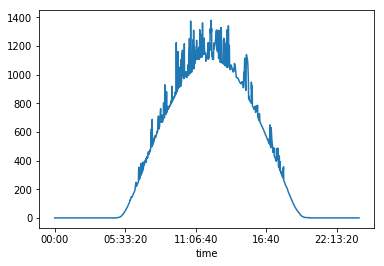

In [19]:
plt.plot(PV_clear_sky[(1,1)]); # 1 January

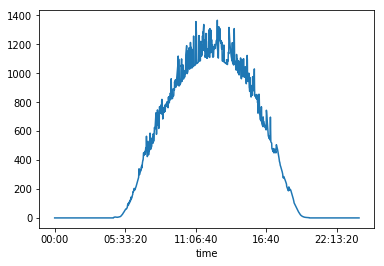

In [20]:
plt.plot(PV_clear_sky[(1,4)]); # 1 April

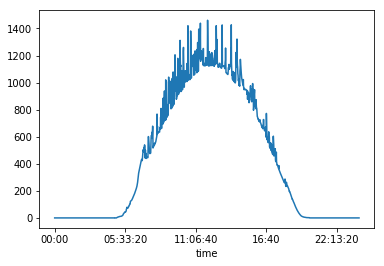

In [21]:
plt.plot(PV_clear_sky[(1,7)]); # 1 July

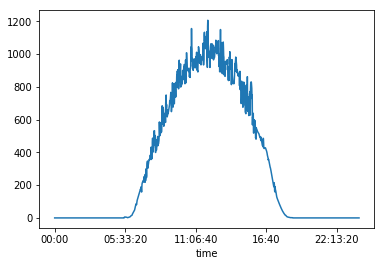

In [22]:
plt.plot(PV_clear_sky[(10,1)]); # 1 October

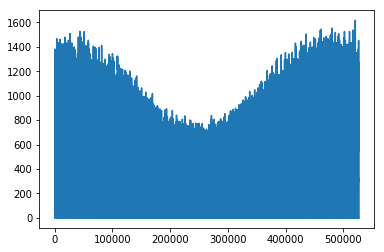

In [23]:
plt.plot(PV_clear_sky.values); # Trend across the year

Add a timestamp field

In [24]:
PV_clear_sky = pd.DataFrame(PV_clear_sky)
PV_clear_sky['t'] = range(1,len(PV_clear_sky)+1)

In [25]:
PV_clear_sky.head()

GHI  t
month_day time_of_day        
(1, 1)    00:00:00     0.0  1
          00:01:00     0.0  2
          00:02:00     0.0  3
          00:03:00     0.0  4
          00:04:00     0.0  5

In [26]:
PV_clear_sky.tail()

GHI       t
month_day time_of_day             
(12, 31)  23:55:00     0.0  527036
          23:56:00     0.0  527037
          23:57:00     0.0  527038
          23:58:00     0.0  527039
          23:59:00     0.0  527040

In [27]:
PV_clear_sky.t.nunique()

527040

### Investigate the Power Spectrum

In [28]:
def power_spectrum(dat,freq_num):
    return(Null)
    # for each frequency to be graphed
        # set s1, s2 and s0 to be zero
        # for each timestamp
            # set s0 to be the timestamp
        # Set the first frequency to be zero
        # Set the first frequency to be the timestamp divided by the number of values
        # for each frequency except the first
            # power
            

In [29]:
# Not yet complete (used John's Excel version instead)

### Build a Fourier Model

In [30]:
# Set frequencies
f1 = 2*np.pi/60/24 
f2 = (1/365.24219)*2*np.pi/60/24
f3 = (1/365.24219*2)*2*np.pi/60/24

freqs = [f1,f2,f3]
freqs

[0.004363323129985824, 1.1946383110849884e-05, 2.3892766221699767e-05]

Creates a matrix where each column is the individual effect of the sine and cosine for each given frequency at each given timestamp. The row sum is the cumululative effect of all frequencies at each timestamp.

In [31]:
def fourier_terms(time_stamp,*args):
    M = np.empty(shape=(len(time_stamp),len(args)*2))
    freq_names = []
    for index,f in enumerate(args):
        M[:,2*index  ] = np.cos(f * time_stamp)
        M[:,2*index+1] = np.sin(f * time_stamp)
        freq_names.append('f'+str(index+1)+'_cos')
        freq_names.append('f'+str(index+1)+'_sin')
    return([M,freq_names])

Apply to our timestamps, creating a set of predictor variables.

In [32]:
X,X_names = fourier_terms(PV_clear_sky.t,*freqs)
X = pd.DataFrame(X, columns=X_names, index=PV_clear_sky.index)

A more natural fit, with fewer parameters, should be possible if the sine/cosine waves in the fitted Fourier model are permitted to go negative at night time. This is achieved by censoring those observed values at zero, i.e. changing them to be missing in the training data.

In [33]:
PV_clear_sky.GHI.replace([0], np.NaN, inplace=True)

Merge the predictors and the outcome variable into a single dataframe for modelling.

In [34]:
model_data = pd.concat([PV_clear_sky.GHI, X], axis=1)
model_data = model_data.dropna()

In [35]:
model_data.head()

GHI    f1_cos    f1_sin    f2_cos    f2_sin    f3_cos  \
month_day time_of_day                                                           
(1, 1)    04:37:00     1.13  0.350207  0.936672  0.999994  0.003321  0.999978   
          04:38:00     1.24  0.346117  0.938191  0.999994  0.003333  0.999978   
          04:39:00     1.08  0.342020  0.939693  0.999994  0.003345  0.999978   
          04:52:00     1.01  0.288196  0.957571  0.999994  0.003500  0.999975   
          04:53:00     1.13  0.284015  0.958820  0.999994  0.003512  0.999975   

                         f3_sin  
month_day time_of_day            
(1, 1)    04:37:00     0.006642  
          04:38:00     0.006666  
          04:39:00     0.006690  
          04:52:00     0.007001  
          04:53:00     0.007024

Fit a multiple linear regression model

In [36]:
lm = linear_model.LinearRegression()
model = lm.fit(model_data[['f1_cos','f1_sin',
                           'f2_cos','f2_sin',
                           'f3_cos','f3_sin']], model_data.GHI)

In [37]:
model.coef_ # Fitted coefficients

array([-919.73705193,  -72.39756058,  281.54191877,  -46.69197893,
        -17.73776916,    2.53479069])

In [38]:
# R-squared - not bad!
lm.score(model_data[['f1_cos','f1_sin',
                           'f2_cos','f2_sin',
                           'f3_cos','f3_sin']],model_data.GHI)

0.9656849309353565

Apply the model to our timestamps to get the predictions

In [39]:
PV_clear_sky['pred'] = model.predict(X)

Replace all negative predictions with zero

In [40]:
PV_clear_sky.loc[PV_clear_sky['pred'] < 0,['pred']] = 0

### Compare the fit to the data

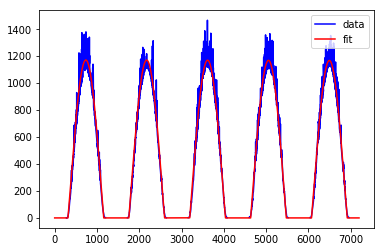

In [41]:
# First 5 days of January
plt.plot(PV_clear_sky.iloc[0:7200,:]['GHI'].values, 'b-', label='data')
plt.plot(PV_clear_sky.iloc[0:7200,:]['pred'].values, 'r-', label='fit')
plt.legend(loc=1)
plt.show();

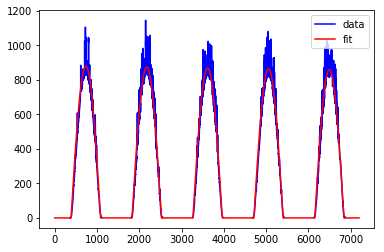

In [42]:
# First 5 days of April
plt.plot(PV_clear_sky.iloc[131040:138240,:]['GHI'].values, 'b-', label='data')
plt.plot(PV_clear_sky.iloc[131040:138240,:]['pred'].values, 'r-', label='fit')
plt.legend(loc=1)
plt.show;

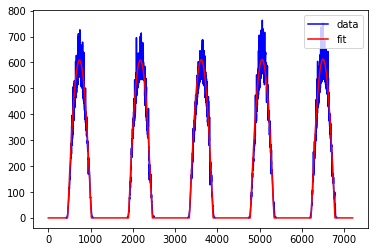

In [43]:
# First 5 days of July
plt.plot(PV_clear_sky.iloc[262080:269280,:]['GHI'].values, 'b-', label='data')
plt.plot(PV_clear_sky.iloc[262080:269280,:]['pred'].values, 'r-', label='fit')
plt.legend(loc=1)
plt.show;

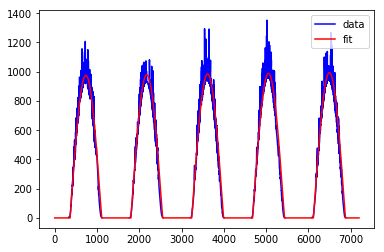

In [44]:
# First 5 days of October
plt.plot(PV_clear_sky.iloc[394560:401760,:]['GHI'].values, 'b-', label='data')
plt.plot(PV_clear_sky.iloc[394560:401760,:]['pred'].values, 'r-', label='fit')
plt.legend(loc=1)
plt.show;

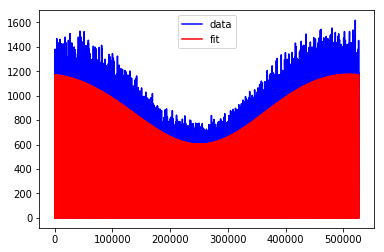

In [45]:
plt.plot(PV_clear_sky.iloc[:,:]['GHI'].values, 'b-', label='data')
plt.plot(PV_clear_sky.iloc[:,:]['pred'].values, 'r-', label='fit')
plt.legend(loc=0)
plt.show;

__Next steps__

* complete power spectrum check in Python
* replicate results using John's suggested normal equations?
* run quantile regression on the lowest quartile

In [46]:
model.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'normalize': False}

### Fit to the 5th percentile of the maximum values using quantile regression.

In [47]:
data = pd.concat([PV_clear_sky,X], axis=1)

In [48]:
data.head()

GHI  t  pred    f1_cos    f1_sin  f2_cos    f2_sin  \
month_day time_of_day                                                       
(1, 1)    00:00:00     NaN  1   0.0  0.999990  0.004363     1.0  0.000012   
          00:01:00     NaN  2   0.0  0.999962  0.008727     1.0  0.000024   
          00:02:00     NaN  3   0.0  0.999914  0.013090     1.0  0.000036   
          00:03:00     NaN  4   0.0  0.999848  0.017452     1.0  0.000048   
          00:04:00     NaN  5   0.0  0.999762  0.021815     1.0  0.000060   

                       f3_cos    f3_sin  
month_day time_of_day                    
(1, 1)    00:00:00        1.0  0.000024  
          00:01:00        1.0  0.000048  
          00:02:00        1.0  0.000072  
          00:03:00        1.0  0.000096  
          00:04:00        1.0  0.000119

In [49]:
mod = smf.quantreg('GHI ~ f1_cos + f1_sin + f2_cos + f2_sin + f3_cos + f3_sin', data)

In [50]:
res = mod.fit(q=0.05)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                    GHI   Pseudo R-squared:               0.8110
Model:                       QuantReg   Bandwidth:                       4.147
Method:                 Least Squares   Sparsity:                        320.2
Date:                Thu, 13 Sep 2018   No. Observations:               283750
Time:                        23:18:58   Df Residuals:                   283743
                                        Df Model:                            6
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -116.3707      0.188   -619.280      0.000    -116.739    -116.002
f1_cos      -941.5150      0.243  -3869.872      0.000    -941.992    -941.038
f1_sin       -79.9758      0.196   -408.445      0.000     -80.360     -79.592
f2_cos       269.1488      0.182   1479.647      0.0

In [51]:
res.params

Intercept   -116.370741
f1_cos      -941.515049
f1_sin       -79.975842
f2_cos       269.148838
f2_sin       -36.567640
f3_cos       -13.516632
f3_sin         8.850974
dtype: float64

In [52]:
PV_clear_sky['pred_Q'] = res.params.Intercept \
+ res.params.f1_cos * X['f1_cos'] \
+ res.params.f1_sin * X['f1_sin'] \
+ res.params.f2_cos * X['f2_cos'] \
+ res.params.f2_sin * X['f2_sin'] \
+ res.params.f3_cos * X['f3_cos'] \
+ res.params.f3_sin * X['f3_sin'] 

In [53]:
len(model_data)

283750

In [54]:
len(X['f1_cos'])

527040

In [55]:
PV_clear_sky.head()

GHI  t  pred      pred_Q
month_day time_of_day                          
(1, 1)    00:00:00     NaN  1   0.0 -802.593807
          00:01:00     NaN  2   0.0 -802.916098
          00:02:00     NaN  3   0.0 -803.220451
          00:03:00     NaN  4   0.0 -803.506860
          00:04:00     NaN  5   0.0 -803.775321

In [56]:
PV_clear_sky.loc[PV_clear_sky['pred_Q'] < 0,['pred_Q']] = 0

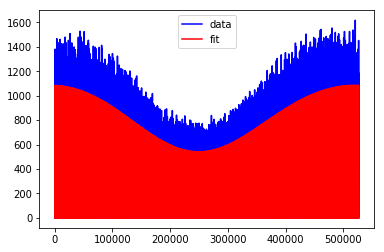

In [57]:
plt.plot(PV_clear_sky.iloc[:,:]['GHI'].values, 'b-', label='data')
plt.plot(PV_clear_sky.iloc[:,:]['pred_Q'].values, 'r-', label='fit')
plt.legend(loc=0)
plt.show;

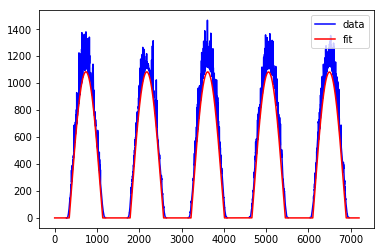

In [58]:
# First 5 days of January
plt.plot(PV_clear_sky.iloc[0:7200,:]['GHI'].values, 'b-', label='data')
plt.plot(PV_clear_sky.iloc[0:7200,:]['pred_Q'].values, 'r-', label='fit')
plt.legend(loc=1)
plt.show();

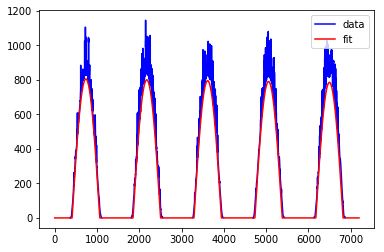

In [59]:
# First 5 days of April
plt.plot(PV_clear_sky.iloc[131040:138240,:]['GHI'].values, 'b-', label='data')
plt.plot(PV_clear_sky.iloc[131040:138240,:]['pred_Q'].values, 'r-', label='fit')
plt.legend(loc=1)
plt.show;

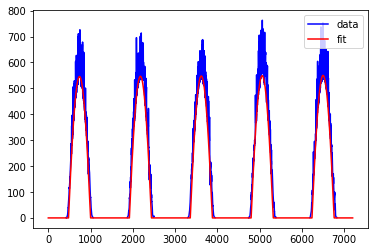

In [60]:
# First 5 days of July
plt.plot(PV_clear_sky.iloc[262080:269280,:]['GHI'].values, 'b-', label='data')
plt.plot(PV_clear_sky.iloc[262080:269280,:]['pred_Q'].values, 'r-', label='fit')
plt.legend(loc=1)
plt.show;

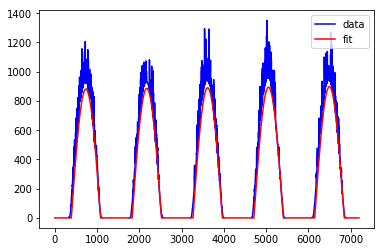

In [61]:
# First 5 days of October
plt.plot(PV_clear_sky.iloc[394560:401760,:]['GHI'].values, 'b-', label='data')
plt.plot(PV_clear_sky.iloc[394560:401760,:]['pred_Q'].values, 'r-', label='fit')
plt.legend(loc=1)
plt.show;

### Apply clear sky model to normalise data

In [62]:
len(PV_clear_sky.GHI)

527040

In [63]:
PV_clear_sky.head()

GHI  t  pred  pred_Q
month_day time_of_day                      
(1, 1)    00:00:00     NaN  1   0.0     0.0
          00:01:00     NaN  2   0.0     0.0
          00:02:00     NaN  3   0.0     0.0
          00:03:00     NaN  4   0.0     0.0
          00:04:00     NaN  5   0.0     0.0

In [64]:
PV.head()

,mean_dir_horiz,mean_diffuse,GHI,year,month_day,time_of_day
date_time,,,,,,
1994-10-27 00:00:00,0.0,0.0,0.0,1994,"(10, 27)",00:00:00
1994-10-27 00:01:00,0.0,0.0,0.0,1994,"(10, 27)",00:01:00
1994-10-27 00:02:00,0.0,0.0,0.0,1994,"(10, 27)",00:02:00
1994-10-27 00:03:00,0.0,0.0,0.0,1994,"(10, 27)",00:03:00
1994-10-27 00:04:00,0.0,0.0,0.0,1994,"(10, 27)",00:04:00


In [65]:
def create_t(date_time):
    return (date_time - dt.datetime(date_time.year,1,1,0,0)).total_seconds() / 60 + 1

In [66]:
x = dt.datetime(1994,1,1,0,0)

In [67]:
x.replace(month=2,day=2)

datetime.datetime(1994, 2, 2, 0, 0)

In [68]:
(PV.index[200000] - dt.datetime(1995,1,1,0,0)).seconds / 60 + 1

1281.0

In [69]:
x.isoformat()

'1994-01-01T00:00:00'

In [70]:
PV['t'] = PV.index.map(create_t)

In [71]:
PV.t.max()

527040.0

In [72]:
X,X_names = fourier_terms(PV.t,*freqs)
X = pd.DataFrame(X, columns=X_names, index=PV.index)

In [73]:
X.head()

,f1_cos,f1_sin,f2_cos,f2_sin,f3_cos,f3_sin
date_time,,,,,,
1994-10-27 00:00:00,0.999990,0.004363,0.418014,-0.908441,-0.650529,-0.759481
1994-10-27 00:01:00,0.999962,0.008727,0.418025,-0.908436,-0.650511,-0.759497
1994-10-27 00:02:00,0.999914,0.013090,0.418035,-0.908431,-0.650493,-0.759512
1994-10-27 00:03:00,0.999848,0.017452,0.418046,-0.908426,-0.650475,-0.759528
1994-10-27 00:04:00,0.999762,0.021815,0.418057,-0.908421,-0.650457,-0.759543


In [74]:
PV['clear_sky'] = model.predict(X)
PV.loc[PV['clear_sky'] < 0,['clear_sky']] = 0

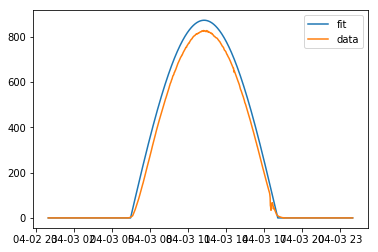

In [75]:
plt.plot(PV['2017-4-3'].clear_sky, label="fit")
plt.plot(PV['2017-4-3'].GHI, label="data")
plt.legend();

In [76]:
PV['resid'] = PV.GHI - PV.clear_sky

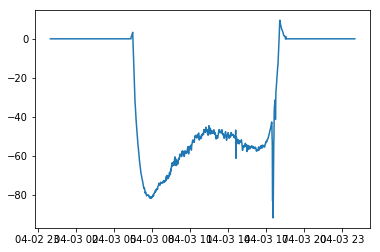

In [77]:
plt.plot(PV.resid['2017-4-3']);

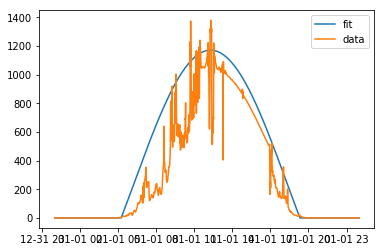

In [78]:
plt.plot(PV['2017-1-1'].clear_sky, label="fit")
plt.plot(PV['2017-1-1'].GHI, label="data")
plt.legend();

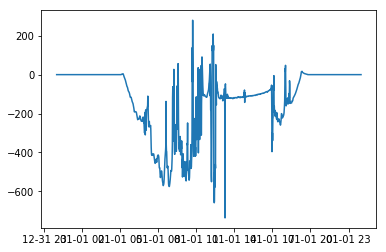

In [79]:
plt.plot(PV.resid['2017-1-1']);

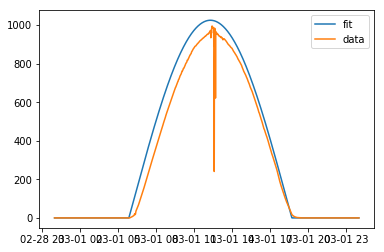

In [80]:
plt.plot(PV['2017-3-1'].clear_sky, label="fit")
plt.plot(PV['2017-3-1'].GHI, label="data")
plt.legend();

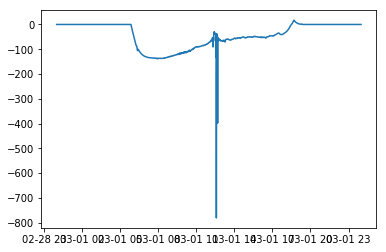

In [81]:
plt.plot(PV.resid['2017-3-1']);

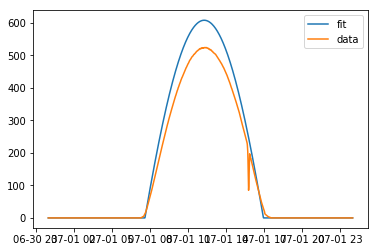

In [82]:
plt.plot(PV['2017-7-1'].clear_sky, label="fit")
plt.plot(PV['2017-7-1'].GHI, label="data")
plt.legend();

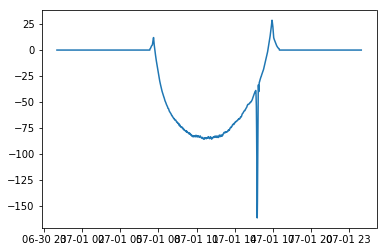

In [83]:
plt.plot(PV.resid['2017-7-1']);

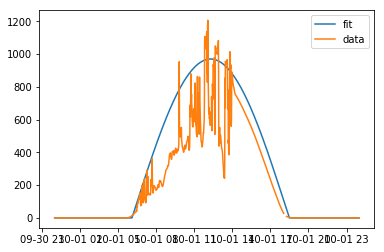

In [84]:
plt.plot(PV['2017-10-1'].clear_sky, label="fit")
plt.plot(PV['2017-10-1'].GHI, label="data")
plt.legend();

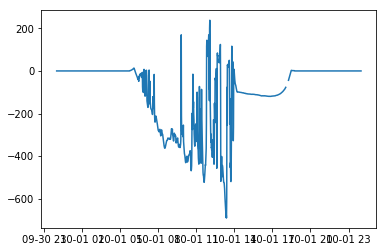

In [85]:
plt.plot(PV.resid['2017-10-1']);

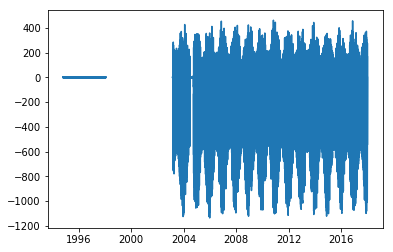

In [86]:
plt.plot(PV.resid);

### Compare quantile regression fit ($5^{th}$ quantile of the maximum) rather than mean of the maximum. 

In [102]:
PV['clear_sky_Q5'] = res.params.Intercept \
+ res.params.f1_cos * X['f1_cos'] \
+ res.params.f1_sin * X['f1_sin'] \
+ res.params.f2_cos * X['f2_cos'] \
+ res.params.f2_sin * X['f2_sin'] \
+ res.params.f3_cos * X['f3_cos'] \
+ res.params.f3_sin * X['f3_sin'] 

PV.loc[PV['clear_sky_Q5'] < 0,['clear_sky_Q5']] = 0

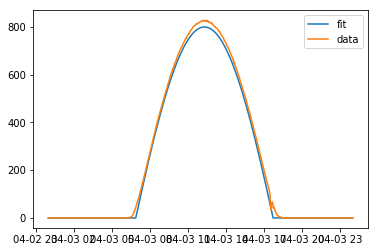

In [103]:
plt.plot(PV['2017-4-3'].clear_sky_Q5, label="fit")
plt.plot(PV['2017-4-3'].GHI, label="data")
plt.legend();

In [104]:
PV['resid_Q5'] = PV.GHI - PV.clear_sky_Q5

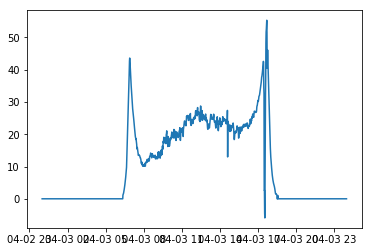

In [105]:
plt.plot(PV.resid_Q5['2017-4-3']);

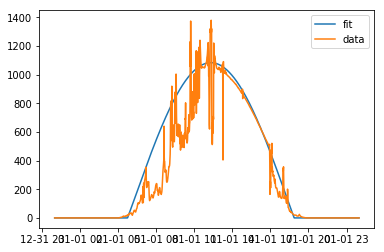

In [106]:
plt.plot(PV['2017-1-1'].clear_sky_Q5, label="fit")
plt.plot(PV['2017-1-1'].GHI, label="data")
plt.legend();

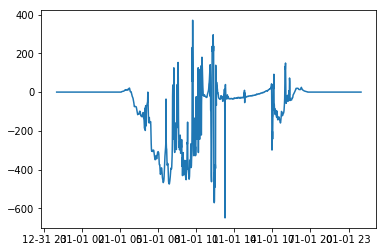

In [107]:
plt.plot(PV.resid_Q5['2017-1-1']);

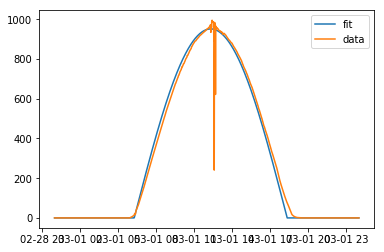

In [108]:
plt.plot(PV['2017-3-1'].clear_sky_Q5, label="fit")
plt.plot(PV['2017-3-1'].GHI, label="data")
plt.legend();

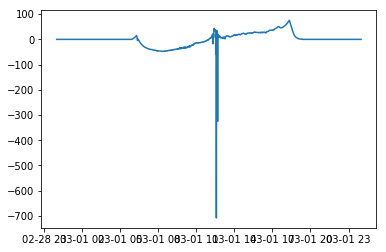

In [109]:
plt.plot(PV.resid_Q5['2017-3-1']);

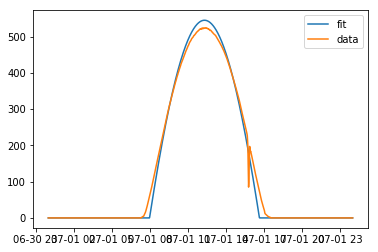

In [110]:
plt.plot(PV['2017-7-1'].clear_sky_Q5, label="fit")
plt.plot(PV['2017-7-1'].GHI, label="data")
plt.legend();

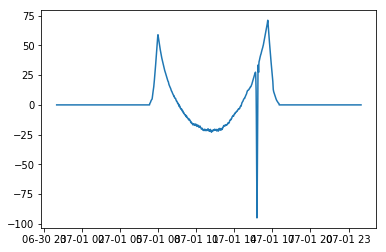

In [111]:
plt.plot(PV.resid_Q5['2017-7-1']);

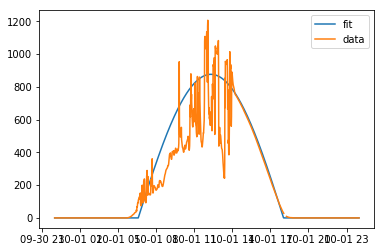

In [112]:
plt.plot(PV['2017-10-1'].clear_sky_Q5, label="fit")
plt.plot(PV['2017-10-1'].GHI, label="data")
plt.legend();

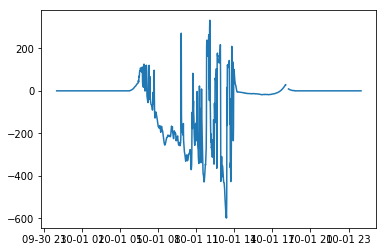

In [113]:
plt.plot(PV.resid_Q5['2017-10-1']);

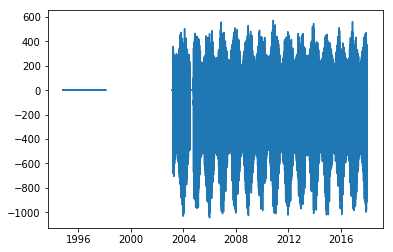

In [114]:
plt.plot(PV.resid_Q5);